In [1]:
# Simple RNN-LSTM regression
# 2017-03-16 jkang
# Python3.5
# Tensorflow1.0.1
#
# input: one sinewave
# output: one sinewave

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input, Ouput dataset
duration = 10  # sec
srate = 10  # Hz
freq = .5  # Hz
amplitude = np.random.random(1) * 10
t = np.linspace(0, duration, duration * srate + 1)
sin = np.sin(2 * np.pi * freq * t) * amplitude
shift = int(srate/freq*1/4) # samples shifted for orthogonally align the output with the input
sin_in = sin[:-shift]
sin_out = sin[shift:]  # shifting

# Hyper-Parameters
learning_rate = 0.01
max_iter = 100

# Network Parameters
n_input_dim = 1
n_input_len = len(sin_in)
n_output_len = len(sin_out)
n_hidden = 50
n_output_dim = 1

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x = tf.placeholder(tf.float32, [1, n_input_len, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y = tf.placeholder(tf.float32, [1, n_output_len, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output_dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output_dim]))
}

In [3]:
def RNN(inputs, weights, biases):
    # Reshape to (time_step) x (batch_size) x (input_dimension)
    inputs = tf.transpose(inputs, [1, 0, 2])
    # Reshape to (time_step)*(batch_size) x (input_dimension)
    inputs = tf.reshape(inputs, [-1, n_input_dim])
    # Split to get a list of time_step tensors of shape (batch_size, input_dimension)
    # final 'inputs' is a list of n_input_len elements (=number of frames)
    inputs = tf.split(value=inputs, num_or_size_splits=n_input_len, axis=0)

    lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32)
#     rnn = tf.contrib.rnn.BasicRNNCell(n_hidden)    
#     outputs, states = tf.nn.dynamic_rnn(rnn, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.squared_difference(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [4]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= max_iter:
        train_x = sin_in.reshape((1, n_input_len, n_input_dim))
        train_y = sin_out.reshape((1, n_output_len, n_output_dim))
        c, _ = sess.run([cost, optimizer], feed_dict={x: train_x, y: train_y})
        print('Epoch =', str(step), '/', str(max_iter),
              'Cost = ', '{:.5f}'.format(c))
        step += 1

    # Test
    pred_out = sess.run(pred, feed_dict={x: train_x})

Epoch = 1 / 100 Cost =  48.36175
Epoch = 2 / 100 Cost =  19.38160
Epoch = 3 / 100 Cost =  7.28115
Epoch = 4 / 100 Cost =  5.70894
Epoch = 5 / 100 Cost =  6.87840
Epoch = 6 / 100 Cost =  8.38422
Epoch = 7 / 100 Cost =  8.02394
Epoch = 8 / 100 Cost =  6.60645
Epoch = 9 / 100 Cost =  5.58471
Epoch = 10 / 100 Cost =  4.93119
Epoch = 11 / 100 Cost =  4.68618
Epoch = 12 / 100 Cost =  4.97875
Epoch = 13 / 100 Cost =  5.27580
Epoch = 14 / 100 Cost =  5.15504
Epoch = 15 / 100 Cost =  4.83380
Epoch = 16 / 100 Cost =  4.46961
Epoch = 17 / 100 Cost =  4.03654
Epoch = 18 / 100 Cost =  3.64613
Epoch = 19 / 100 Cost =  3.49224
Epoch = 20 / 100 Cost =  3.48541
Epoch = 21 / 100 Cost =  3.42250
Epoch = 22 / 100 Cost =  3.37585
Epoch = 23 / 100 Cost =  3.30762
Epoch = 24 / 100 Cost =  3.10409
Epoch = 25 / 100 Cost =  2.89161
Epoch = 26 / 100 Cost =  2.72323
Epoch = 27 / 100 Cost =  2.52632
Epoch = 28 / 100 Cost =  2.41391
Epoch = 29 / 100 Cost =  2.36295
Epoch = 30 / 100 Cost =  2.29080
Epoch = 31 / 100 

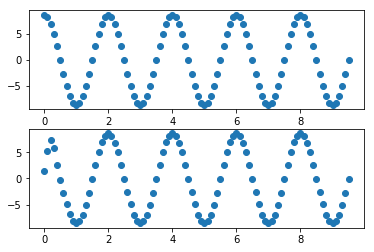

In [6]:
# Plot
f, axes = plt.subplots(2, sharey=True)
axes[0].plot(t[:-shift], sin_out, 'o')
axes[1].plot(t[:-shift], pred_out, 'o')
plt.show()

### Further thoughts

* For future, the proper number of shifting should be decided. Here, I tried to shift samples to make the output to be orthogonal to the input in correlation. 
* Windowing might be needed to learn more local shapes